In [1]:
from dotenv import load_dotenv
from IPython.display import Markdown, display
import os

import session_config
from session_config import  collect_survey_data, feature_variables, agg_groups
from reports import make_report_objects, reports_and_forecast
from reports import admin_report, features_present, histograms_standard
from reports import ecdf_plots_standard, scatter_plot_standard
from reports import labels_for_display, make_standard_report, make_report_objects
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display, Markdown
from myst_nb import glue
from shapely.geometry import Point

from haystack import Pipeline, Document
from haystack.utils import Secret
from haystack.document_stores.in_memory import InMemoryDocumentStore
# from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.generators import OpenAIGenerator
# from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder

from haystack.components.converters import MarkdownToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.filter_retriever import FilterRetriever

from haystack.components.converters.pypdf import PyPDFToDocument
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack import component

/home/roger/anaconda3/envs/haystack2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')
model = 'gpt-4o-mini' # 'gpt-4o'

def print_results(results, reply_object='llm'):
    return Markdown(result[reply_object]['replies'][0])   

# report_document_store = InMemoryDocumentStore()

# document_pipeline = Pipeline()
# document_pipeline.add_component("converter", MarkdownToDocument())
# document_pipeline.add_component("cleaner", DocumentCleaner())
# document_pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=10))
# document_pipeline.add_component("writer", DocumentWriter(document_store=report_document_store))
# document_pipeline.connect("converter", "cleaner")
# document_pipeline.connect("cleaner", "splitter")
# document_pipeline.connect("splitter", "writer")

# document_pipeline.run({"converter": {
#     "sources": ["vaud_report_results.md", "report_results.md", "lac_leman_g70.md"], 
#     'meta':[
#         {'doc-id': 'Vaud 2015-11-15 2021-12-31', 'topic':'reports'}, 
#         {'doc-id': 'Bern 2015-11-15 2021-12-31', 'topic':'reports'},
#         {'doc-id': 'Lac Léman 2015-11-15 2021-12-31', 'topic': 'reports'}
#     ]
#     }})

prompt_template = """
    You are a report writer for a data analyis section.\n
    Given these documents, answer the question in a profesional manner.\n
    Please provide the name of the reference(s) in your response\nDocuments:\n
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
    """

# report_pipeline = Pipeline()
# report_pipeline.add_component(name="retriever", instance=FilterRetriever(document_store=report_document_store))
# report_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")
# report_pipeline.add_component(instance=OpenAIGenerator(model=model), name="llm")
# report_pipeline.connect("retriever", "prompt_builder.documents")
# report_pipeline.connect("prompt_builder", "llm")

file_names = [
    'resources/brief_history_marine_litter.pdf', 
    'resources/coastline_litter_threshold_value_report_14_9_2020_final.pdf', 
    'resources/revealing_the_role_of_landuse.pdf',
    'resources/Walvoort-ea-2021-Modelling-Forecasting-Beach-Litter-Assessment-Values-1.pdf',
    'resources/eu-guide-marine-litter-2023.pdf',
    'resources/land-use-marine-litter-malaysia.pdf'
]
metas = [
    {'topic': 'history of research, methods of research'},  
    {'topic': 'threshold values, methods of calculation'}, 
    {'topic': 'geospatial analysis, land use, feature evaluation'},
    {'topic': 'methods of calculation, threshold values'},
    {'topic': 'sampling protocls, methods of research'},
    {'topic': 'geospatial analysis, land use, feature evaluation'}
]


# context_document_store = ChromaDocumentStore()

# pipeline = Pipeline()
# pipeline.add_component("converter", PyPDFToDocument())
# pipeline.add_component("cleaner", DocumentCleaner())
# pipeline.add_component("splitter", DocumentSplitter(split_by="page", split_length=1))
# pipeline.add_component("writer", DocumentWriter(document_store=context_document_store))
# pipeline.connect("converter", "cleaner")
# pipeline.connect("cleaner", "splitter")
# pipeline.connect("splitter", "writer")

# pipeline.run({"converter": {"sources": file_names, "meta": metas}})

# prompt_template = """
#     You are a report writer for a data analyis section.\n
#     Given these documents, answer the question in a profesional manner.\n
#     Please provide the name of the reference(s) in your response\nDocuments:\n
#     {% for doc in documents %}
#         {{ doc.content }}
#     {% endfor %}

#     \nQuestion: {{question}}
#     \nAnswer:
#     """

# context_pipeline = Pipeline()
# context_pipeline.add_component(name="context_retriever", instance=FilterRetriever(document_store=context_document_store))
# context_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder_context")
# context_pipeline.add_component(instance=OpenAIGenerator( model=model), name="llm")
# context_pipeline.connect("context_retriever", "prompt_builder_context.documents")
# context_pipeline.connect("prompt_builder_context", "llm")

In [3]:
def context_pipeline_func(query: str):
    print("context called")
    if 'context_filter' in query:
        result = context_pipeline.run({"retriever": {"filters": context_filters}, "prompt_builder": {"question": query}})

        return {"reply": result["llm"]["replies"][0].content}
    else:
        return "There is no relevant background in my library"

def report_pipeline_func(query: str, filters: dict):
    print("report called")
    if 'report_filters' in query:
        result = context_pipeline.run({"retriever": {"filters": filters}, "prompt_builder": {"question": query}})
        return {"reply": result["llm"]["replies"][0].content}
    else:
        return "There is no survey data for that date range and location, would you like a list of available cantons?"

def call_tools(query, a_report_filter, a_context_filter):

    report = report_pipeline_func(qeury, a_report_filter)
    context = context_pipeline_func(query, a_context_filter)

    return (f'the requested survey results:\n\n {report}\n\nSome relevant background info {context}')


# result[reply_object]['replies'][0]

@component
class AssembleResources:
    def __init__(self, query: str, report_filters: dict, context_filters: dict, context_pipeline: Pipeline, report_pipeline: Pipeline, reply_object: str = 'llm'):
        self.report_filter = report_filters
        self.context_filter = context_filters
        self.query = query
        self.cont_pipeline = context_pipeline
        self.rep_pipeline = report_pipeline
        self.reply_object = reply_object
        

    @component.output_types(report_results=str, context_results=str)
    def run(self):
        r = self.rep_pipeline.run({'retriever': {'filters': self.report_filter}, "prompt_builder":{"question":self.query}})
        c = self.cont_pipeline.run({'context_retriever': {'filters': self.context_filter}, "prompt_builder_context":{"question":self.query}})
        return {'report_results': r[self.reply_object]['replies'][0], 'context_results':c[self.reply_object]['replies'][0]}


In [4]:




def map_markers(df, lat_lon: pd.DataFrame = None):
    """Map the markers"""
    nsamples = df.groupby('location', observed=True)['sample_id'].nunique()
    qty_location = df.groupby('location', observed=True)['quantity'].sum()
    rate_location = df.groupby('location', observed=True)['pcs/m'].mean().round(2)
    last_sample = df.groupby('location', observed=True)['date'].max()
    df = pd.concat([nsamples, qty_location, rate_location, last_sample], axis=1)
    df = df.merge(lat_lon, left_index=True, right_index=True)
    df['location'] = df.index
    max_lat, min_lat = df['latitude'].max(), df['latitude'].min()
    max_lon, min_lon = df['longitude'].max(), df['longitude'].min()
    td = df.to_dict(orient='records')
    geometry = [Point(loc['longitude'], loc['latitude']) for loc in td]
    geo_frame = gpd.GeoDataFrame(td, geometry=geometry, crs="EPSG:4326")
    
    return geo_frame , {'max_lat': max_lat, 'min_lat': min_lat, 'max_lon': max_lon, 'min_lon': min_lon}

def scatter_plot_display(report_results, standard_report, name: str = "Name of report"):

    points = []
    dates = "" 
    
    if report_results['prior_report'] != 'No prior':
        pp = (report_results['prior_report'].sample_results(), standard_report['prior-labels'], session_config.palette['prior'])
        points.append(pp)
        dates += standard_report['prior-labels'][:4]
        dates += ' - ' 
    if report_results['this_report'] != 'No likelihood':
        lp = (report_results['this_report'].sample_results(), standard_report['likelihood-labels'], session_config.palette['likelihood'])
        points.append(lp)
        dates += standard_report['likelihood-labels'][-4:]
    
    title = f'All samples {name}: {dates}'
    
    

    return scatter_plot_standard(points), title


## the survey data and code definitions
datax = collect_survey_data()
codes = pd.read_csv('data/end_process/codes.csv').set_index('code')

# the coordinates of the survey locations
beaches = pd.read_csv('data/end_process/beaches.csv')
lat_lon = beaches[['slug', 'latitude', 'longitude']].set_index('slug')

# these are the dates of the federal report
o_dates = {'start':'2020-01-01', 'end':'2021-12-31'}

# these are all the samples before then
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}

# these are the parameters we are interested in
this_feature_type = 'l'
region_type = 'Lake'
# the name of the feature
afeature ='lac-leman'
# the objects of interest
objs_of_interest = ['G70']
# usage
obj_use = 'pers'
# information columns
# aggregates or subsets that are of administrative interest
info_columns = ['use', 'canton', 'city', 'feature_name']

# the name of the report
report_name = 'Le Léman'

# query the data
d = datax.reset_index(drop=True)

d = d[d.feature_name == afeature].copy()
d = d[d.code.isin(objs_of_interest)].copy()

# this grabs all the data that is on lakes but not lac-leman
# this excludes records in the likelihood, we use these samples
# thise samples serve as a basis for comparison and prediction
# we make report objects and use them as the prior
lu_catalogue = datax[(datax.feature_name != afeature)&(datax['date'] <= o_dates['end'])&(datax.feature_type == 'l')&(datax.code.isin(objs_of_interest))].copy()
lu_catalogue.reset_index(inplace=True, drop=True)
catalog_surveys, catalog_features = make_report_objects(lu_catalogue)

# this is the prior data: all data collected from
# the same feature type. Lakes, rivers or parks
prior_feature = catalog_features.df_cat
prior_feature['feature_type'] = this_feature_type

# this is the likelihood data, the data from the most recent sampling campaign
all_data_of_interest = d[(d['date'] >= prior_dates['start']) & (d['date'] <= o_dates['end'])].copy()
all_data_of_interest['use'] = obj_use
all_data_of_interest.reset_index(inplace=True, drop=True)

# land_covers = ['buildings', 'forest', 'undefined', 'public-services', 'streets', 'orchards', 'use', 'canton', 'city', 'feature_name']

all_report, all_land_use = make_report_objects(all_data_of_interest, info_columns=info_columns)

args = {
    'likelihood': {'feature_name':afeature, 'date_range':o_dates},
    'prior' : {'feature_name':afeature, 'date_range':prior_dates},
    'data' : all_data_of_interest.copy(),
    'land-use-inventory' : prior_feature.copy()
}



combined_results = reports_and_forecast(args['likelihood'], args['prior'], ldata=args['data'])
standard_combined = make_standard_report(combined_results, args)

lake_report = combined_results['this_report']
lake_prior_report = combined_results['prior_report']
lake_land_use = combined_results['this_land_use']

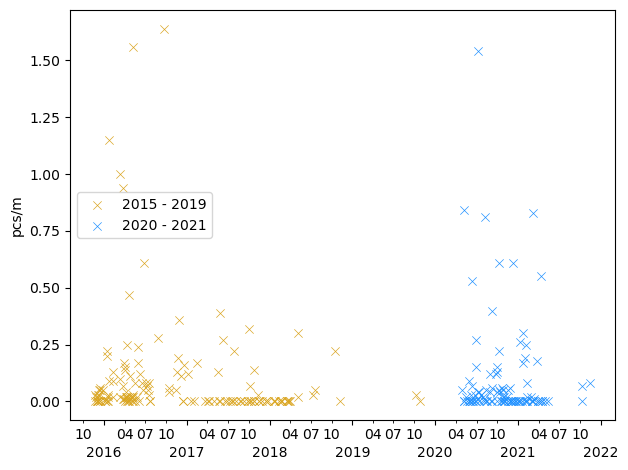

In [5]:
fig, title = scatter_plot_display(combined_results, standard_combined, name=report_name)
glue('scatter-plot-summary', fig, display=True)

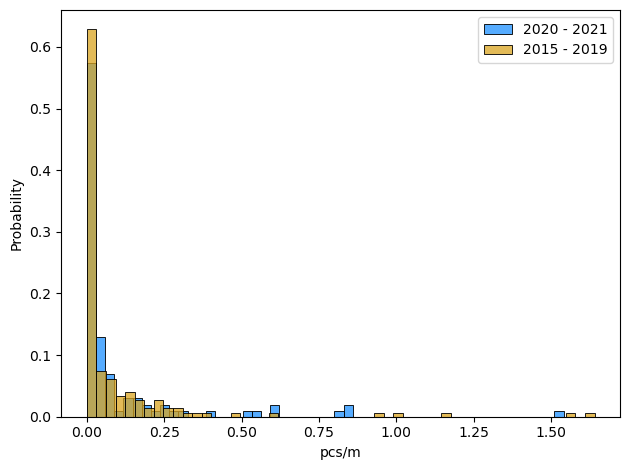

In [6]:
lake_histogram_of_results = histograms_standard(standard_combined['observed-values'])
glue('histogram-of_results', lake_histogram_of_results, display=True)

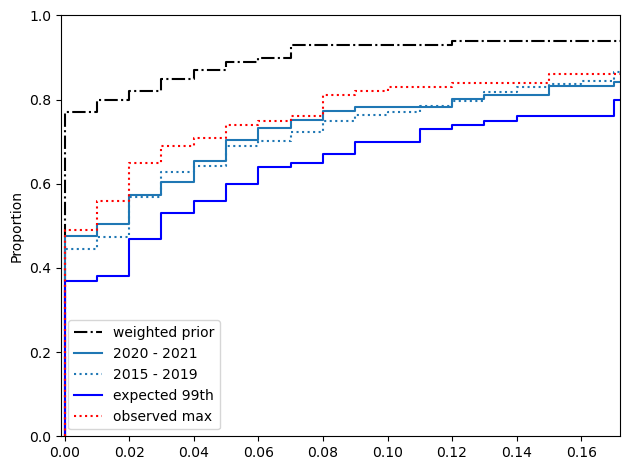

In [7]:
lake_forecasted_distributions = ecdf_plots_standard(standard_combined['forecasted-values'])
glue('forecasts', lake_forecasted_distributions, display=True)

In [8]:
cantons = ['Vaud', 'Valais', 'Genève']

dbc = gpd.read_file('data/ignorethis/shapes/kantons.shp')
dbc = dbc.to_crs(epsg=4326)
dbc = dbc[dbc.NAME.isin(cantons)].copy()
dbckey = dbc[['NAME', 'KANTONSNUM']].set_index('NAME')
dbckey = dbckey.drop_duplicates()
thiscanton = dbckey.loc[cantons, 'KANTONSNUM']
thiscanton.values

array(['CH22000000', 'CH23000000', 'CH25000000'], dtype=object)

In [9]:
context_document_store = ChromaDocumentStore()

document_pipeline = Pipeline()
document_pipeline.add_component("converter", MarkdownToDocument())
document_pipeline.add_component("cleaner", DocumentCleaner())
document_pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=10))
document_pipeline.add_component("writer", DocumentWriter(document_store=context_document_store))
document_pipeline.connect("converter", "cleaner")
document_pipeline.connect("cleaner", "splitter")
document_pipeline.connect("splitter", "writer")

document_pipeline.run({"converter": {
    "sources": ["vaud_report_results.md", "report_results.md", "lac_leman_g70.md"], 
    'meta':[
        {'doc-id': 'Vaud 2015-11-15 2021-12-31', 'topic':'reports'}, 
        {'doc-id': 'Bern 2015-11-15 2021-12-31', 'topic':'reports'},
        {'doc-id': 'Lac Léman 2015-11-15 2021-12-31', 'topic': 'reports'}
    ]
    }})

pipeline = Pipeline()
pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="page", split_length=1))
pipeline.add_component("writer", DocumentWriter(document_store=context_document_store))
pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "writer")

file_names = [
    'resources/brief_history_marine_litter.pdf', 
    'resources/coastline_litter_threshold_value_report_14_9_2020_final.pdf', 
    'resources/revealing_the_role_of_landuse.pdf',
    'resources/Walvoort-ea-2021-Modelling-Forecasting-Beach-Litter-Assessment-Values-1.pdf',
    'resources/eu-guide-marine-litter-2023.pdf',
    'resources/land-use-marine-litter-malaysia.pdf'
]
metas = [
    {'topic': 'history of research, methods of research'},  
    {'topic': 'threshold values, methods of calculation'}, 
    {'topic': 'geospatial analysis, land use, feature evaluation'},
    {'topic': 'threshold values, methods of calculation'},
    {'topic': 'sampling protocols, methods of research'},
    {'topic': 'geospatial analysis, land use, feature evaluation'}
]


pipeline.run({"converter": {"sources": file_names, "meta": metas}})

Converting markdown files to Documents: 100%|█████| 3/3 [00:00<00:00, 80.85it/s]


{'writer': {'documents_written': 365}}

In [17]:
v = ['Vaud 2015-11-15 2021-12-31']
b = ['Bern 2015-11-15 2021-12-31']
l = ['Lac Léman 2015-11-15 2021-12-31']
report_filters = {
    'doc-id': {"$in":[*l] },
    'topic':{"$in":['threshold values, methods of calculation']}
}
# fs = [
#     {"field": "meta.topic", "operator": "in", "value":['threshold values, methods of calculation']},
#     {"field": "meta.doc-id", "operator": "in", "value":['Lac Léman 2015-11-15 2021-12-31']},
# ]

# query = {"context_retriever": {
#     		"AND": [
#         			{"field": "meta.topic", "operator": "in", "value":['threshold values, methods of calculation']},
#                     {"field": "meta.doc-id", "operator": "in", "value":['Lac Léman 2015-11-15 2021-12-31']},
#       					]
#     			   }
  		      
#        }

filters = { "operator": "$and",
      			"conditions": [
        			{"field": "meta.topic", "operator": "in", "value":['threshold values, methods of calculation']},
                    {"field": "meta.doc-id", "operator": "in", "value":['Lac Léman 2015-11-15 2021-12-31']},
      					]
    			   }
# {"topic": {'$in':['threshold values, methods of calculation']}}
retriever = FilterRetriever(context_document_store)
result = retriever.run(filters)

# { "operator": "AND",
#   "conditions": [
#             {"field": "meta-key-a", "operator": "==", "value": "param-a"},
#             {"field": "meta-key-b", "operator": "==", "value": "param-b"}
#         ]
# }

ChromaDocumentStoreFilterError: Expected where to have exactly one operator, got {'operator': '$and', '$or': [{'conditions': {'field': 'meta.topic', 'operator': 'in', 'value': ['threshold values, methods of calculation']}}, {'conditions': {'field': 'meta.doc-id', 'operator': 'in', 'value': ['Lac Léman 2015-11-15 2021-12-31']}}]}

In [11]:
len(result['documents'])

15

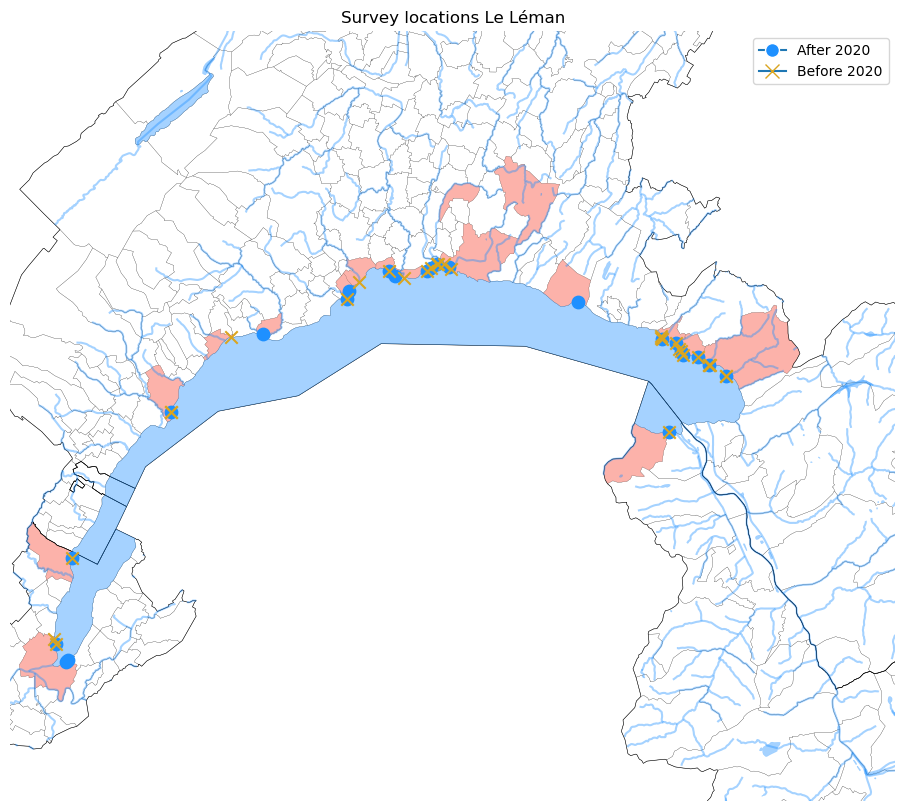

In [10]:
# Create a GeoDataFrame from the list of locations
dbc = gpd.read_file('data/ignorethis/shapes/kantons.shp')
dbc = dbc.to_crs(epsg=4326)
dbc = dbc[dbc.NAME.isin(cantons)].copy()
dbckey = dbc[['NAME', 'KANTONSNUM']].set_index('NAME')
dbckey = dbckey.drop_duplicates()
thiscanton = dbckey.loc[cantons, 'KANTONSNUM']
db = gpd.read_file('data/ignorethis/shapes/municipalities.shp')
db = db.to_crs(epsg=4326)
thesecities = db[db.KANTONSNUM.isin(thiscanton.values)]
surveyedcities = all_data_of_interest.city.unique()

bounds = dbc.total_bounds
minx, miny, maxx, maxy = 6.0, 46.1, 7.0, 46.8


rivers = gpd.read_file('data/ignorethis/shapes/rivers.shp')
rivers = rivers.to_crs(epsg=4326)
# Filter the background layer to cover the bounding box
rivers_within_bounds = rivers.clip(dbc, keep_geom_type=True) # cx[minx:maxx, miny:maxy]


lakes = gpd.read_file('data/ignorethis/shapes/lakes.shp')
lakes = lakes.to_crs(epsg=4326)
lakes_within_bounds = lakes.clip(dbc, keep_geom_type=True) # [minx:maxx, miny:maxy]

# Define the plot
fig, ax = plt.subplots(figsize=(12,10))
ax.set_xlim(6.1, 7.1)
ax.set_ylim(46.1, 46.7)

citymap = thesecities.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=.1)

surveyed = thesecities[thesecities.NAME.isin(surveyedcities)].plot(ax=ax, color='salmon', alpha=0.6)

dbc.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=.4)
rivers_within_bounds.plot(ax=ax, edgecolor='dodgerblue', alpha=.4)
lakes_within_bounds.plot(ax=ax, edgecolor='dodgerblue', color='dodgerblue', linewidth=.2, alpha=.4)

lakes = lake_report.sample_results()
prior_samples = lake_prior_report.sample_results()

lakes_locations,  map_boundsa = map_markers(lakes, lat_lon)
lakes_locations.plot(ax=ax, color= session_config.palette['likelihood'], markersize=80, zorder=5)

prior_locations,  map_boundsb = map_markers(prior_samples, lat_lon)
prior_locations.plot(ax=ax, color= session_config.palette['prior'], marker='x', markersize=80, zorder=5)

ax.set_title(f'Survey locations {report_name}')
plt.xlabel('')
plt.ylabel('')

plt.axis('off')



legend_elements = [
    Line2D([0], [0], marker='o', label='After 2020', markersize=10, markeredgecolor='w', markerfacecolor= session_config.palette['likelihood']),
    Line2D([0], [0], marker='x', label='Before 2020', markersize=10, markeredgecolor= session_config.palette['prior'])
]

plt.legend(handles=legend_elements, loc='upper right')

glue('map-of-survey-locations', fig, display=True)
plt.close()

# Le Léman plastic shotgun wadding: observations 2015 - 2021

## Geographic range

1. How many cities and cantons are included in the leman report?
2. What are the objects that are consedered?
3. Why do we study plastics and trash in the water?

In [11]:
context_pipeline = Pipeline()
context_pipeline.add_component(name="context_retriever", instance=FilterRetriever(document_store=context_document_store))
context_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder_context")
context_pipeline.add_component(instance=OpenAIGenerator( model=model), name="llm")
context_pipeline.connect("context_retriever", "prompt_builder_context.documents")
t = context_pipeline.connect("prompt_builder_context", "llm")

🚅 Components
  - context_retriever: FilterRetriever
  - prompt_builder_context: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - context_retriever.documents -> prompt_builder_context.documents (List[Document])
  - prompt_builder_context.prompt -> llm.prompt (str)

In [77]:
v = ['Vaud 2015-11-15 2021-12-31']
b = ['Bern 2015-11-15 2021-12-31']
l = ['Lac Léman 2015-11-15 2021-12-31']
combined = [*v,*b,*l]
# context_filters = {
#     'topic': {"$in":['threshold values, methods of calculation']},
# }


report_filters = {
    'doc-id': {"$in":[*l] },
    'topic':{"in":['threshold values, methods of calculation']}
}

question = (
    "How many cities and cantons are included in the leman report? "
    "What are the objects that are consedered? "
    "Why do we study plastics and trash in the water?")
    
q = context_pipeline.run({'context_retriever': {'filters': report_filters}, "prompt_builder_context":{"question":question}})

NameError: name 'context_pipeline' is not defined

In [16]:
Markdown(q['llm']['replies'][0])

The Lac Léman report includes a total of **13 cities** and **3 cantons**. The surveyed cities are La Tour-de-Peilz, Préverenges, Lausanne, Genève, Vevey, Bourg-en-Lavaux, Saint-Sulpice (VD), Tolochenaz, Gland, Montreux, Saint-Gingolph, Allaman, and Versoix. The 3 cantons represented in the data are Vaud, Genève, and Valais.

In terms of objects considered in the study, the report identifies plastic shotgun wadding as the sole item recorded. A total of **354 pieces** of this plastic object were collected during the survey, making it account for **100%** of the total objects found.

The study of plastics and trash in water is crucial for several reasons. Primarily, plastics pose significant environmental hazards, particularly in aquatic ecosystems, where they can harm marine life and disrupt the ecological balance. The presence of trash, including plastic waste, can lead to pollution, which affects not only the health of aquatic organisms but also public health and aesthetic values of natural water bodies. Additionally, understanding the sources and densities of plastic waste can inform strategies for better waste management and pollution prevention, ultimately contributing to the health of the aquatic environment and the broader ecosystem.

**References**: 
Lac Léman Report 2015-11-15 - 2021-12-31.

## Summary statistics

In [30]:
v = ['Vaud 2015-11-15 2021-12-31']
b = ['Bern 2015-11-15 2021-12-31']
l = ['Lac Léman 2015-11-15 2021-12-31']
combined = [*v,*b,*l]
# context_filters = {
#     'topic': {"$in":['threshold values, methods of calculation']},
# }


report_filters = {
    'doc-id': {"$in":l },
}

question = (
    "What were the summary statistics for the period? What was th average objects per meter?"
    )
    
q2 = context_pipeline.run({'context_retriever': {'filters': report_filters}, "prompt_builder_context":{"question":question}})

In [31]:
Markdown(q2['llm']['replies'][0])

The summary statistics for the survey period spanning from April 28, 2020, to November 14, 2021, indicate a total of 354 objects identified across 101 samples. The average number of objects per meter, or density of litter, was approximately 0.104059 pieces per meter. The distribution of objects recorded varied significantly across the samples, with the 5th and 25th percentiles both reflecting a value of 0 objects per meter, indicating that a considerable number of samples recorded no litter. The median (50th percentile) was slightly above zero at 0.01 objects per meter. The values increased through the percentiles, with the 75th percentile at 0.07 objects per meter and a substantial rise observed at the 95th percentile, which showed a value of 0.61 objects per meter. The standard deviation of the observations was noted to be 0.231, suggesting variability in litter density across the samples collected. The maximum recorded density reached up to 1.54 objects per meter.

These statistics provide a comprehensive overview of litter density along the surveyed locations, emphasizing both the average conditions and the variability observed during the study period. 

Reference: Survey report Lake Lac Léman 2015-11-15 2021-12-31.

In [34]:
question = (
    "How is average pcs/m calculated? What other statistical methods are used to assess the amount of trash on the beach ?"    
    "What other metrics are used to measure beach litter ?"
)
report_filters = {
    'doc-id': {"$in":['threshold values, methods of calculation'] },
}
q3 = context_pipeline.run({'context_retriever': {'filters': report_filters}, "prompt_builder_context":{"question":question}})

In [35]:
Markdown(q3['llm']['replies'][0])

The average pieces per square meter (pcs/m) are calculated by dividing the total number of pieces of litter collected during a beach cleanup by the total area (in square meters) that was surveyed. This method provides a standardized measure to gauge the density of litter on the beach, facilitating comparisons between different locations or times.

In addition to calculating average pcs/m, other statistical methods employed to assess the amount of trash on the beach include:

1. **Total Count**: This method simply sums the total number of litter items collected across a predefined area or along a stretch of beach.

2. **Composition Analysis**: This involves categorizing the litter into different types (e.g., plastics, glass, metal) to understand the proportion of each type present, which can inform targeted cleanup efforts.

3. **Density Distribution**: This method assesses the distribution of litter densities across different sections of the beach to identify hotspots of accumulation.

4. **Temporal Comparisons**: Statistical analyses can be conducted to compare litter counts over time, identifying trends and patterns in beach litter accumulation.

Other metrics used to measure beach litter include:

- **Weight of Collected Litter**: Measuring the total weight of litter collected can provide insight into the overall burden of trash on the beach, which can complement the pcs/m metric.

- **Litter Index**: Some studies employ a litter index that scores beaches based on the amount and types of litter found, utilizing a standardized scale.

- **Cleanliness Rating**: Surveys or visual assessments can be conducted to rate beaches based on their perceived cleanliness, which can help gauge public perception of litter conditions.

These methodologies and metrics collectively enhance our understanding of beach litter and support effective management and cleanup strategies.

References: [Not directly provided in the prompt]

In [ ]:
break

```{glue:md} political-boundaries
:format: myst
```

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Named features Bern 2015-11-15 2021-12-31 : The lakes, rivers and parks'
instructions = 'Please answer in paragraph form and label your response with "### Features of interest"'

surveyed_features = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('surveyed-features', Markdown(surveyed_features['answer']), display=False)

```{glue:md} surveyed-features
:format: myst
```

```{glue} map-of-survey-locations
```

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Summary statistics Bern 2015-11-15 2021-12-31: The descriptive statistics of the survey results'
instructions = 'Identify the average pcs/m, the 90% interval, anwer in paragraph form and label your response: "### Summary of survey results"'

summary_results = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('summary-results', Markdown(summary_results['answer']), display=False)

```{glue:md} summary-results
:format: myst
```

```{glue} scatter-plot-summary
```

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Inventory items Bern 2015-11-15 2021-12-31 : The complete list of the objects found and indentified included in this report.'
instructions = 'What was The quantity, average density, % of total and fail rate per object category of the top two items? Answer in paragraph format and provide a table of values. How many were found? Label your response"### Inventory and most common".'

inventory = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('inventory', Markdown(inventory['answer']), display=False)

```{glue:md} inventory
:format: myst
```

In [ ]:
sample_read = f"""
\n\n
__Example of how to interpret sampling-stratification table:__\n\n
#
__Sample table:__\n\n

|   Proportion of buffer zone |   ('Proportion of samples collected', 'buildings') |   ('Proportion of samples collected', 'wetlands') |   ('Proportion of samples collected', 'forest') |   ('Proportion of samples collected', 'public-services') |   ('Proportion of samples collected', 'recreation') |   ('Proportion of samples collected', 'undefined') |   ('Proportion of samples collected', 'streets') |   ('Proportion of samples collected', 'vineyards') |   ('Proportion of samples collected', 'orchards') |
|----------------------------:|---------------------------------------------------:|--------------------------------------------------:|------------------------------------------------:|---------------------------------------------------------:|----------------------------------------------------:|---------------------------------------------------:|-------------------------------------------------:|---------------------------------------------------:|--------------------------------------------------:|
|                           1 |                                          0.0588235 |                                                 1 |                                       0.976471  |                                                0.776471  |                                                   1 |                                          0.870588  |                                                0 |                                          0.976471  |                                                 1 |
|                           2 |                                          0.0588235 |                                                 0 |                                       0.0235294 |                                                0.2       |                                                   0 |                                          0.0470588 |                                                0 |                                          0         |                                                 0 |
|                           3 |                                          0.0117647 |                                                 0 |                                       0         |                                                0.0235294 |                                                   0 |                                          0.0823529 |                                                0 |                                          0.0235294 |                                                 0 |
|                           4 |                                          0.376471  |                                                 0 |                                       0         |                                                0         |                                                   0 |                                          0         |                                                0 |                                          0         |                                                 0 |
|                           5 |                                          0.494118  |                                                 0 |                                       0         |                                                0         |                                                   0 |                                          0         |                                                0 |                                          0         |                                                 0 |


__exmple paragraph__

The sampling-stratification of the surveys was as follows: 49% of the surveys were conducted at locations where 80-100% of the buffer was dedicated to buidlings. 37% of the surveys were taken where 60 -80% of the buffer
was dedicated to buidlings. 1% of the surveys were taken where 40-60% of the buffer was dedicated to buidlings. 6% of the samples were taken from locations where 20 - 40% of the buffer was dedicated to buidlings. 
6% of samples was taken from locations where 0-20% of the buffer was dedicated to buidlings. All of the samples were taken in locations where 0-20% of the buffer was dedicated to wetlands. 98% of the samples were 
taken from locations where 0-20% of the buffer was dedicated to forest. 2% of surveys were taken where 20-40% of the buffer was dedicated to forest. 77% of the samples were taken from locations that had
0-20% of the buffer dedicated to public-services. 20% of the surveys were taken from locations that had 20-40% of the buffer dedicated to public services. 2% of surveys were taked from locations that had
20-40% of the buffer dedicated to public services.
"""


In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Sampling stratification Bern 2015-11-15 2021-12-31: The environmental features surrounding the survey location'
instructions = [
    "The sampling stratification quantifies what proportion of the samples were conducted according to the proportion of the buffer zone that is dedicated to a particular land use feature.",
    "Each survey location is surrounded by a buffer zone of radius = 1 500 meters. The buffer zone is comprised of land-use features, each land use feature occupies a proportion of the buffer zone (0 - 100%). ",
    "The sampling stratification is the proportions of samples taken for each land use feature and the proportion of buffer zone that the feature occupies. Each location has the same size buffer zone. ",
    "What changes is how the land use features are distributed within the buffer zone. You are given a table of vaues. Here is an example of how to read it: ",
    "Suppose the proportion of buffer is 0 - 20% and the value for buidlings is .3, that means that 30% of the samples took place at locations where 0-20% of the buffer is dedicated to buildlings. ",
    "Another example: Suppose on the same table for proportion of buffer 40-60% forests = .24, that means that 24% of samples were taken 40-60% was dedidcated to forest. ",
    "What is a buffer zone? What is sample stratification? What role does land use play? Summarize the table of values using the examples provided above"
    "\n\nPlease label your response '### Sampling stratification'"
]
instructions = "".join(instructions)
sampling_stratification = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('sampling-stratification', Markdown(sampling_stratification['answer']), display=False)

In [ ]:
 Markdown(sampling_stratification['answer'])

```{glue:md} sampling-stratification
:format: myst
```

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Topography and trash density Bern 2015-11-15 2021-12-31: The changes in the observed litter density and the changes in land use'
instructions = "Provide a narrative paragraph, and the table of values. note where the pcs/m is highest and lowest. Please label your response '### Topography and trash density'"
instructions = "".join(instructions)
sampling_stratification = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('stratification-pcs-m', Markdown(sampling_stratification['answer']), display=False)

```{glue:md} stratification-pcs-m
:format: myst
```

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Cluster analysis Bern 2015-11-15 2021-12-31'
instructions = 'Discuss the noteable differences in compostion of the clusters and the differences in the sample average per cluster in paragrpah form. Provide a table of values. Please Label your response "### Cluster Analysis".'
language = 'english'
reply_language = f"\n\nPlease reply in the following language: {language}"
cluster_analysis = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}{reply_language}'})
glue('cluster-analysis', Markdown(cluster_analysis['answer']), display=False)

```{glue:md} cluster-analysis
:format: myst
```

### Cluster analysis and land-use

1. Does the average density per cluster, support any conclusions that could be drawn given the land-use profile?
2. Is their any possible correlations?

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Cluster analysis Bern 2015-11-15 2021-12-31'
instructions = 'Does the average density per cluster, support any conclusions that could be drawn given the land-use profile? Is their any possible correlations? Please answer in paragraph form.'

cluster_analysis_lu = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('cluster-analysis-lu', Markdown(cluster_analysis_lu['answer']), display=False)

```{glue:md} cluster-analysis-lu
:format: myst
``` 

## Regression Analysis

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Summary of regression methods Bern 2015-11-15 2021-12-31: The different linear models the data were tested on'
instructions = 'Given the r² values of the regression models how accurate would the predictions be? How accurate would the best model be? How much faith can we put in the predictions ? Answer in paragraph form. Label your response"### Summary of regression methods".'

regression_methods = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('regression-methods', Markdown(regression_methods['answer']), display=False)

```{glue:md} regression-methods
:format: myst
``` 

In [ ]:
requesting = 'Please summarize the following sections:'
sections_to_summarize = 'Forecasts grid approximation Bern 2015-11-15 2021-12-31'
instructions = 'Explain what a grid forecast is. Explain each forecast method. Given the results from the forecast methods estimate a probable range of values. Label your response"### Forecasts for 2025".'

forecasts = data_chait.invoke({'input': f'{requesting} {sections_to_summarize}\n\nInstructions\n\n{instructions}'})
glue('forecasts',Markdown(forecasts['answer']), display=False)

```{glue:md} forecasts
:format: myst
``` 